# Linear Regression in scikit-learn

## OLS - simple run

Adpated from [this example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-py).

The dataset is [this toy dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) provided by scikit-learn.

In [63]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the diabetes dataset
X, y = load_diabetes(return_X_y=True)
X = X[:, [2]]  # Use only one feature
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)

In [64]:
# Fit the linear regression model
regressor = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Print the mean squared error and r^2
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"r^2: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 2548.07
r^2: 0.47


In [65]:
# print regressor coefficients
print(f"Coefficient: {regressor.coef_}")
print(f"Intercept: {regressor.intercept_}")

Coefficient: [938.23786125]
Intercept: 152.91886182616113


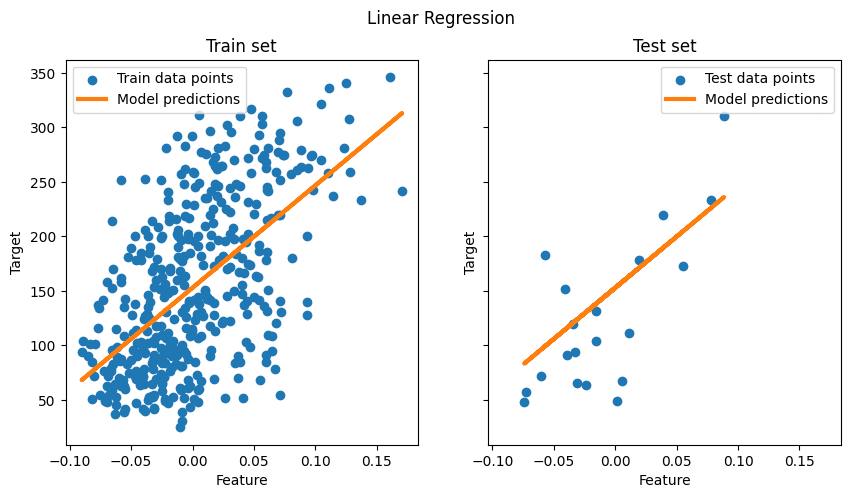

In [66]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].scatter(X_train, y_train, label="Train data points")
ax[0].plot(
    X_train,
    regressor.predict(X_train),
    linewidth=3,
    color="tab:orange",
    label="Model predictions",
)
ax[0].set(xlabel="Feature", ylabel="Target", title="Train set")
ax[0].legend()

ax[1].scatter(X_test, y_test, label="Test data points")
ax[1].plot(X_test, y_pred, linewidth=3, color="tab:orange", label="Model predictions")
ax[1].set(xlabel="Feature", ylabel="Target", title="Test set")
ax[1].legend()

fig.suptitle("Linear Regression")

plt.show()

## Deep dive LR with multiple features

In [67]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load the diabetes dataset
X, y = load_diabetes(return_X_y=True)
diabetes = load_diabetes()
feature_names = np.array(diabetes.feature_names)

# Standardize the features and target variable
StandardScaler = StandardScaler()
X = StandardScaler.fit_transform(X)
y = StandardScaler.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)

In [68]:
# Fit the linear regression model
new_regressor = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = new_regressor.predict(X_test)

# Print the mean squared error and r^2
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"r^2: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 0.34
r^2: 0.59


By introducing new features, we can see the MSE dropped and the r2_score increase indicating a potentially better fit. Let's dive into the model to see how we can make improvements.

### Check LR assumption

#### Homoscedasticity - is variance of the residual constant? 
Check for Heteroscedasticity by the **scale-location plot** below.

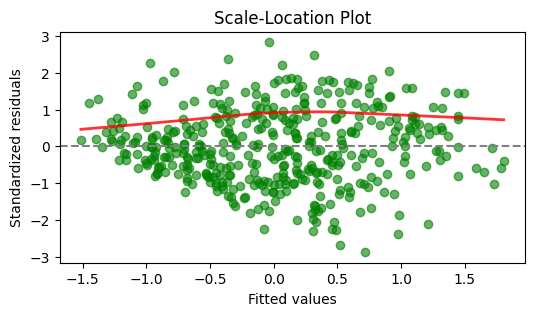

In [69]:
# Scale-location plot: standardized residuals vs fitted values
import numpy as np
import seaborn as sns

# Fitted values for train and test
fitted_values = new_regressor.predict(X_train)

# Residuals for train and test
residuals_values = y_train - fitted_values

# Standardized residuals
std_resid = residuals_values / np.std(residuals_values)

plt.figure(figsize=(6,3))
plt.scatter(fitted_values, std_resid, color='green', alpha=0.6)
plt.axhline(0, color='grey', linestyle='--')
sns.regplot(x=fitted_values, y=np.sqrt(np.abs(std_resid)),
            scatter=False, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

plt.xlabel('Fitted values')
plt.ylabel('Standardized residuals')
plt.title('Scale-Location Plot')
plt.show()

**Interpretation of the Scale-Location Plot**

The scale-location plot displays standardized residuals versus fitted values. The residuals are spread equally along the range of fitted values (forming a horizontal band), this suggests homoscedasticity (constant variance).

#### Normality - is the distribution of Y normal?

Check for normality by QQ-plot

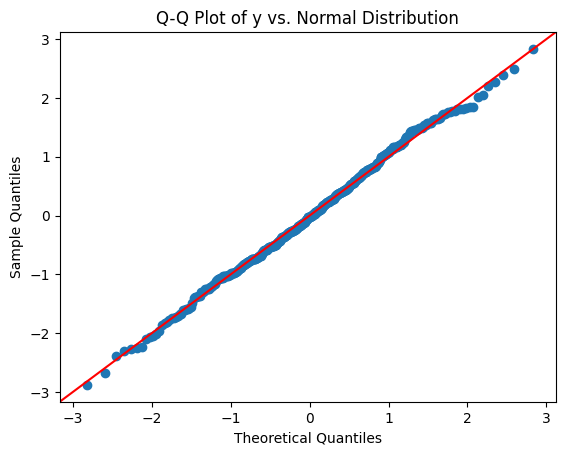

In [70]:
import statsmodels.api as sm

fig = sm.qqplot(std_resid, line='45')
plt.title("Q-Q Plot of y vs. Normal Distribution")
plt.show()

**Interpretation of QQ-plot**

From the plot we can see the points follow the 45-degree reference line closely, so the residuals are normally distributed.

### Assess multicollinearity


Variance Inflation Factors:
[np.float64(1.2173065138070072), np.float64(1.2780710154103625), np.float64(1.509437373844549), np.float64(1.4594277776838303), np.float64(59.202510134318615), np.float64(39.1933699727707), np.float64(15.402156007513453), np.float64(8.890986360329634), np.float64(10.075967132038336), np.float64(1.484622607383483)]


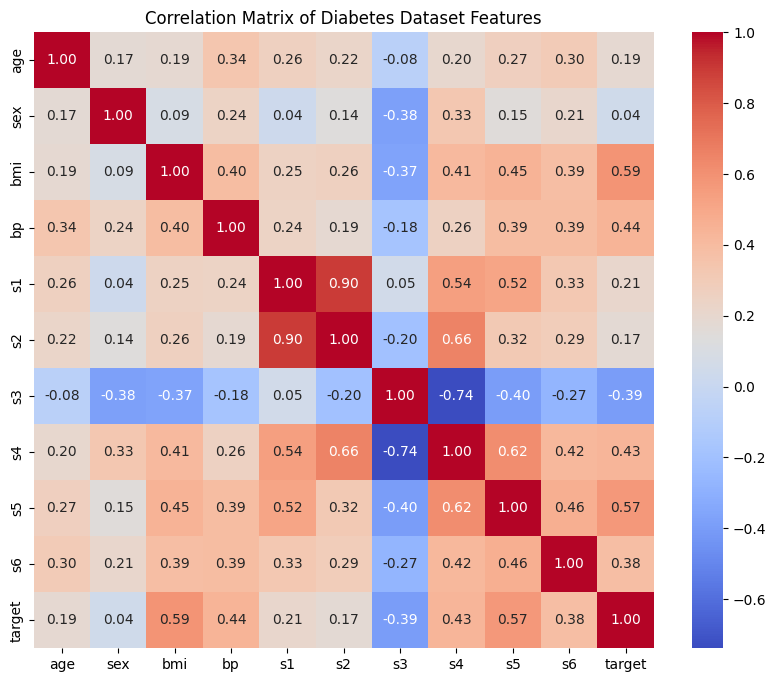

In [71]:
# Calculate and plot the correlation matrix for the diabetes dataset
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert the diabetes dataset to a DataFrame for easier correlation analysis
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df.columns = feature_names
df['target'] = y

# Calculate Variance Inflation Factor (VIF) for each feature
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Calculate the correlation matrix
corr_matrix = df.corr()

print("\nVariance Inflation Factors:")
print(vif)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Diabetes Dataset Features')
plt.show()

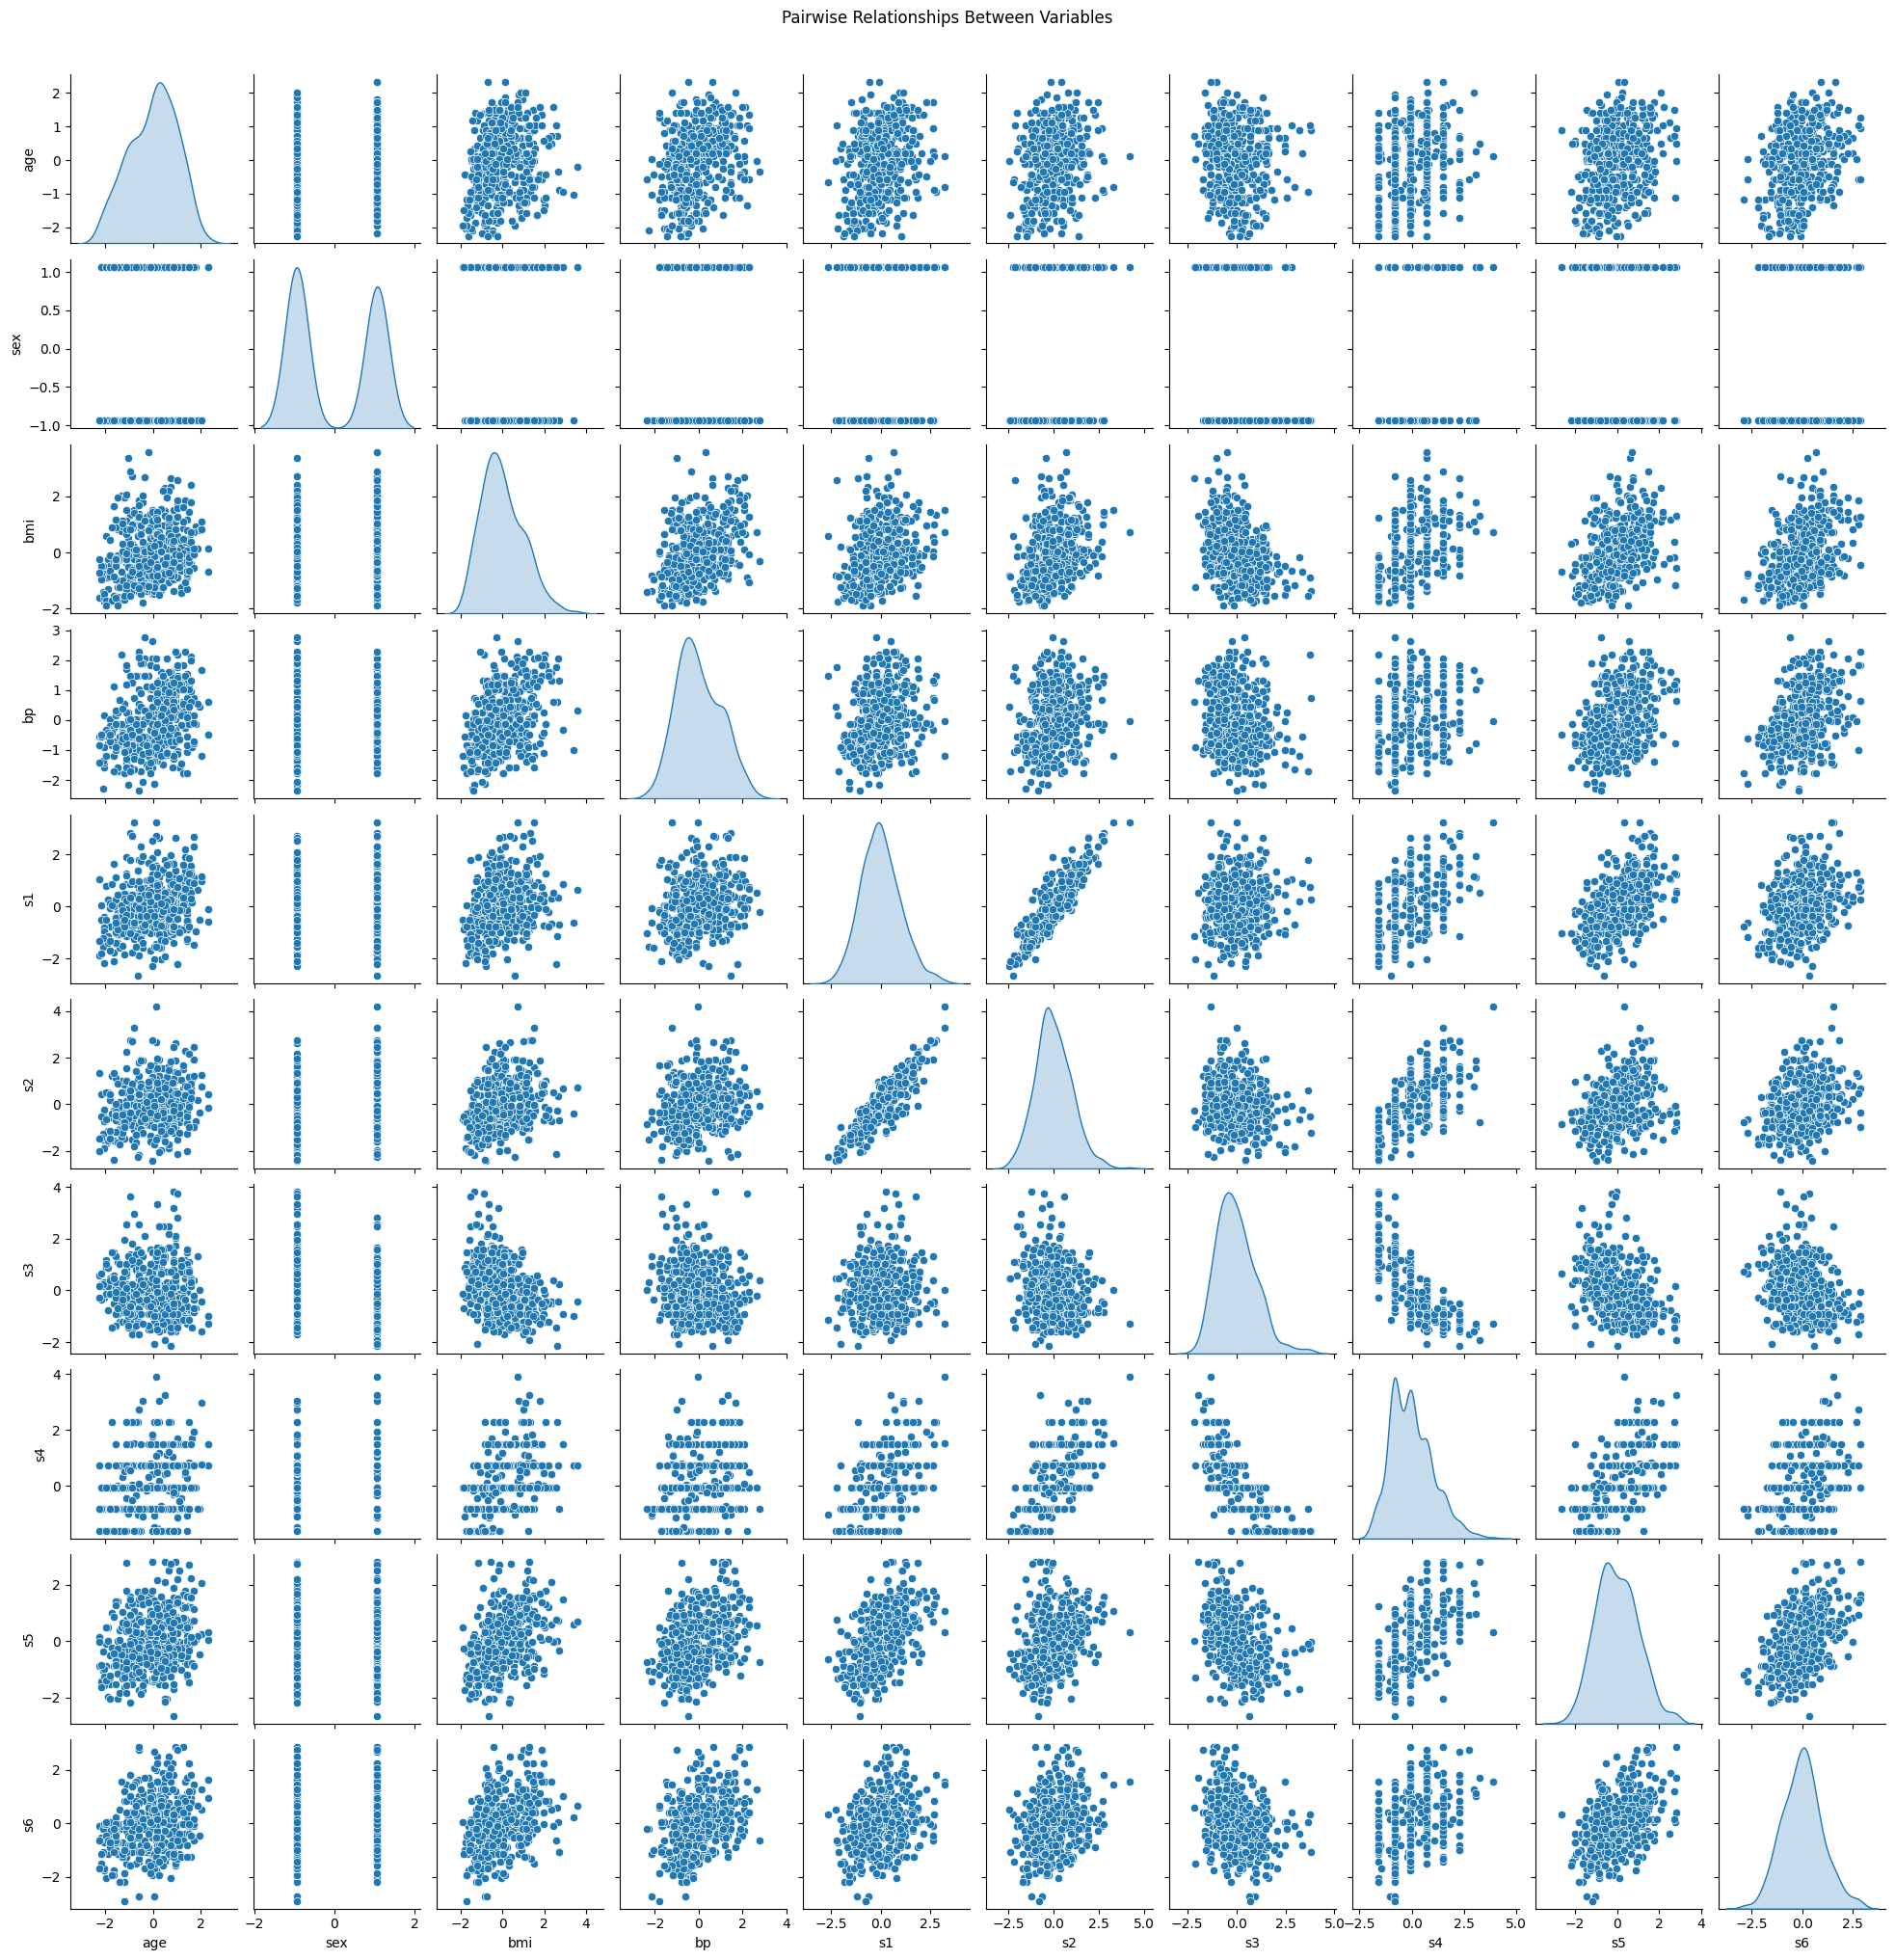

In [72]:
# Create a pairplot to visualize relationships between variables
sns.pairplot(df[[col for col in df.columns if col != 'target']], diag_kind='kde', height=2)
plt.suptitle('Pairwise Relationships Between Variables', y=1.02)
plt.show()

##### Conclusion

There’s **strong multicollinearity** concentrated in a few features.

- Heatmap: clear clusters — **s\_1 ↔ s\_2 ≈ 0.90**, **s\_3 ↔ s\_4 ≈ −0.74** (large magnitude still problematic), and **s\_4/8 with 4/5 (≈0.5–0.6)**.
- VIFs (rule-of-thumb: >5 concerning, >10 severe; $\mathrm{VIF}_j=\frac{1}{1-R_j^2}$):
  - Severe: **s\_1 ≈ 59**, **s\_2 ≈ 39**, **s\_3 ≈ 15**, **s\_5 ≈ 10**.
  - Moderate–high: **s\_4 ≈ 8.9**.
  - Low/acceptable: **features 0,1,2,3,9 ≈ 1.2–1.5**.

**Interpretation:** OLS coefficients for features 4–8 will be unstable with inflated standard errors (possible sign flips). Features 0,1,2,3,9 are fine.

**What to do (brief):** drop/merge one of {s1,s2} and one of {s3,s4}; or switch to regularization (ridge/elastic-net) or dimensionality reduction (PCA).


### Improvments

#### Handling with collinear features - subset selection

A common way to reduce model complexity is by adding feature selection process.

There are multiple ways to perform automatic feature selection:
- Selection based on feature weights - see more at [feature-importance-from-coefficients](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#feature-importance-from-coefficients)
- Sequential selection (forward & backward) - see below

In [73]:
# Forward and backward sequential feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from time import time

ridge_cv_regressor = RidgeCV(alphas=np.logspace(-6, 6, 13))

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge_cv_regressor, n_features_to_select=6, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge_cv_regressor, n_features_to_select=6, direction="backward"
).fit(X, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['sex' 'bmi' 'bp' 's1' 's3' 's5']
Done in 0.131s
Features selected by backward sequential selection: ['sex' 'bmi' 'bp' 's1' 's2' 's5']
Done in 0.105s


#### Fit with advanced models

In [79]:
ridge_regressor = Ridge().fit(X_train, y_train)
ridge_cv_regressor = RidgeCV(alphas=np.logspace(-6, 6, 13)).fit(X_train, y_train)

# Make predictions
y_pred = ridge_regressor.predict(X_test)
y_pred_cv = ridge_cv_regressor.predict(X_test)

# Print the mean squared error and coefficient of determination
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"r^2: {r2_score(y_test, y_pred):.2f}")
print('-'*50)
print(f"Mean squared error (RidgeCV): {mean_squared_error(y_test, y_pred_cv):.2f}")
print(f"r^2 (RidgeCV): {r2_score(y_test, y_pred_cv):.2f}")
print(f"Alpha (RidgeCV): {ridge_cv_regressor.alpha_}")

Mean squared error: 0.34
r^2: 0.59
--------------------------------------------------
Mean squared error (RidgeCV): 0.34
r^2 (RidgeCV): 0.59
Alpha (RidgeCV): 1.0


In [80]:
lasso_regressor = Lasso().fit(X_train, y_train)
lasso_cv_regressor = LassoCV(alphas=np.logspace(-6, 6, 13)).fit(X_train, y_train)

# Make predictions
y_pred = lasso_regressor.predict(X_test)
y_pred_cv = lasso_cv_regressor.predict(X_test)

# Print the mean squared error and r^2
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"r^2: {r2_score(y_test, y_pred):.2f}")
print('-'*50)
print(f"Mean squared error (LassoCV): {mean_squared_error(y_test, y_pred_cv):.2f}")
print(f"r^2 (LassoCV): {r2_score(y_test, y_pred_cv):.2f}")
print(f"Alpha (LassoCV): {lasso_cv_regressor.alpha_}")

Mean squared error: 0.94
r^2: -0.15
--------------------------------------------------
Mean squared error (LassoCV): 0.34
r^2 (LassoCV): 0.59
Alpha (LassoCV): 0.01


Compare to the basic LR results:

```txt
Mean squared error: 2004.52

r^2: 0.59
```
We can find basic `Ridge` and `Lasso` did a worse job on this problem. With built-in cross validation to select hyperparameter `alpha`, we could achieve a similar level of performance, however at those cases, the alpha is relatively small, suggesting the regularization is not make a huge difference.

##### Proceed with selected features

In [76]:
# Get the mask of selected features
forward_selected_mask = sfs_forward.get_support()

lr_regressor_f = LinearRegression()
ridge_regressor_f = RidgeCV(alphas=np.logspace(-6, 6, 13))
lasso_regressor_f = LassoCV(alphas=np.logspace(-6, 6, 13))

# Subset the training and test data
X_train_f_selected = X_train[:, forward_selected_mask]
X_test_f_selected = X_test[:, forward_selected_mask]

# Retrain Ridge regressor
lr_f_selected = lr_regressor_f.fit(X_train_f_selected, y_train)
ridge_f_selected = ridge_regressor_f.fit(X_train_f_selected, y_train)
lasso_f_selected = lasso_regressor_f.fit(X_train_f_selected, y_train)

# Predict and evaluate
y_pred_lr_f_selected = lr_f_selected.predict(X_test_f_selected)
y_pred_ridge_f_selected = ridge_regressor_f.predict(X_test_f_selected)
y_pred_lasso_f_selected = lasso_regressor_f.predict(X_test_f_selected)
print(f"Mean squared error (forward selected features): {mean_squared_error(y_test, y_pred_lr_f_selected):.2f}")
print(f"Mean abosolute error (forward selected features): {mean_absolute_error(y_test, y_pred_lr_f_selected):.2f}")
print(f"r^2 (forward selected features): {r2_score(y_test, y_pred_lr_f_selected):.2f}")
print('-'*50)
print(f"Mean squared error (forward selected features, RidgeCV): {mean_squared_error(y_test, y_pred_ridge_f_selected):.2f}")
print(f"Mean abosolute error (forward selected features): {mean_absolute_error(y_test, y_pred_ridge_f_selected):.2f}")
print(f"r^2 (forward selected features, RidgeCV): {r2_score(y_test, y_pred_ridge_f_selected):.2f}")
print(f"alpha (RidgeCV): {ridge_f_selected.alpha_}")
print('-'*50)
print(f"Mean squared error (forward selected features, LassoCV): {mean_squared_error(y_test, y_pred_lasso_f_selected):.2f}")
print(f"Mean abosolute error (forward selected features): {mean_absolute_error(y_test, y_pred_lasso_f_selected):.2f}")
print(f"r^2 (forward selected features, LassoCV): {r2_score(y_test, y_pred_lasso_f_selected):.2f}")
print(f"Alpha (LassoCV): {lasso_f_selected.alpha_}")                                                              


Mean squared error (forward selected features): 0.33
Mean abosolute error (forward selected features): 0.48
r^2 (forward selected features): 0.60
--------------------------------------------------
Mean squared error (forward selected features, RidgeCV): 0.33
Mean abosolute error (forward selected features): 0.48
r^2 (forward selected features, RidgeCV): 0.60
alpha (RidgeCV): 10.0
--------------------------------------------------
Mean squared error (forward selected features, LassoCV): 0.33
Mean abosolute error (forward selected features): 0.48
r^2 (forward selected features, LassoCV): 0.60
Alpha (LassoCV): 1e-06


#### Introducing polynomial features

In [81]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

poly = PolynomialFeatures(degree=2, include_bias=False)
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13))

pipeline = make_pipeline(StandardScaler(), poly, ridge_cv)
pipeline.fit(X_train_f_selected, y_train)
y_pred_poly = pipeline.predict(X_test_f_selected)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred_poly):.2f}, Mean absolute error: {mean_absolute_error(y_test, y_pred_poly):.2f}")
print(f"R^2: {r2_score(y_test, y_pred_poly):.2f}")
print(f"Alpha: {ridge_cv.alpha_}")

Mean squared error: 0.28, Mean absolute error: 0.45
R^2: 0.66
Alpha: 100.0


In [82]:
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13))
pipeline = make_pipeline(StandardScaler(), poly, lasso_cv)
pipeline.fit(X_train_f_selected, y_train)
y_pred_poly = pipeline.predict(X_test_f_selected)
print(f"Mean squared error: {mean_squared_error(y_test, y_pred_poly):.2f}, Mean absolute error: {mean_absolute_error(y_test, y_pred_poly):.2f}")
print(f"R^2: {r2_score(y_test, y_pred_poly):.2f}")
print(f"Alpha: {ridge_cv.alpha_}")

Mean squared error: 0.25, Mean absolute error: 0.41
R^2: 0.69
Alpha: 100.0


## Summary & Key takeaways

This notebook demonstrates a comprehensive analysis of linear regression on the diabetes dataset, progressing from basic implementation to advanced techniques. Here are the key takeaways:

1. **Model Evolution & Performance**:
   - Simple linear regression with one feature: Limited performance (low R² score)
   - Multiple feature regression: Improved performance but revealed multicollinearity issues
   - Feature selection and advanced models: Achieved better model stability

2. **Linear Regression Assumptions Check**:
   - Homoscedasticity: Confirmed through scale-location plot showing constant variance
   - Normality: QQ-plot confirmed normally distributed residuals
   - Multicollinearity: Significant issues detected through correlation matrix and VIF analysis

3. **Feature Engineering & Selection**:
   - Strong multicollinearity identified between feature pairs (s1↔s2, s3↔s4)
   - Feature selection using forward/backward selection helped reduce dimensionality
   - Some features showed severe VIF (>10): s1, s2, s3, s5

4. **Model Improvements**:
   - Ridge and Lasso regularization with CV showed similar performance to base model
   - Small alpha values in regularized models suggest minimal impact of regularization
   - Feature selection improved performance
   - Polynomial features improved performance